# Rate Based Model

The purpose of this code is to get to simulating a rate-based approximation of the Brunel and Wang 2001 model.

I'll use the quasi-stationary approach, where the firing rate is modeled as converging onto the mean-field predicted firing rates with a time constant equal to that of the membrane potential.

Given a model like
$$
\tau_E(t) \frac{dV(t)}{dt} = -(V(t) - V_L) + \mu_E(t) + \sigma_E(t) \sqrt{\tau_E}\eta(t)
$$
we can infer via mean-field methods an estimated firing rate of each population $n$ of via equations of the form
$$
\nu_n(t) = \phi(h_n(t), \sigma_E^n(t))
$$
and the input potential $h_n(t)$ follows dynamics
$$
\tau_E(t) \frac{dh_n(t)}{dt} = -\left(h_n(t) - \mu_E(t)\right)
$$

The basic equation looks like this:

$$
\begin{split}
C_m \frac{dV(t)}{dt} =& -g_m(V(t) - V_L) \\
    &-\sum_{k=0}^p \left[ g_{AMPA,rec}(V(t) - V_E)\sum_{j=1}^{C_k}w_j^A s_j^{AMPA,rec}(t) \right. \\
    &\quad\quad + \left. \frac{g_{NMDA}(V(t) - V_E)}{1 + \gamma \exp(-\beta V(t))}\sum_{j=1}^{C_k} w_j^N s_j^{NMDA}(t) \right]\\
    &-g_{GABA}(V(t) - V_I) \sum_{j=1}^{C_I} w_j^I s_j^{GABA}(t)\\
    &-g_{AMPA, ext}(V(t) - V_E)\sum_{j=1}^{C_{ext}} s_j^{AMPA,ext}(t)
\end{split}
$$

and we use the simplifications like:
$$
g_{NMDA}^{k', k} = \frac{g_{NMDA}}{C_k} \sum_{j=1}^{C_k} w_j^N = g_{NMDA} \langle w_j^N \rangle_{C_k}
$$

So we need to specify:
$$
C_m, g_m, V_L, V_E, V_I, V_{reset}, V_{thr}, g_{NMDA}, g_{GABA}, g_{AMPA,ext}, g_{AMPA,rec}, C_{ext}, \beta, \gamma, \langle w_j^N \rangle_{C_k}, \langle w_j^A \rangle_{C_k}, C_k \text{ for all $k$ }, C_I, \langle w_j^I \rangle_{C_I}
$$

We have two options:  
1. Use `brian2`, either with [custom functions](https://brian2.readthedocs.io/en/stable/advanced/functions.html) to implement the rate-based network, or manually computing rates for `NeuronGroup`s. Synapses will be clock based, continually updating rates  
2. Implement the network with mild OOP principles and possibly a `networkx` graph

In [443]:
import brian2 as b2
import networkx as nx
from brian2 import numpy_ as np
from brian2 import plt
from scipy import special, integrate
from pprint import pprint


population_graph = nx.DiGraph()

defaultdt = 0.1 * b2.ms

N = 1000
N_E = int(N * 0.8)
N_I = int(N * 0.2)
f = 0.1
p = 5
N_sub = int(N_E * f)
N_non = int(N_E * (1. - f * p))
w_plus = 2.1
w_minus = 1. - f * (w_plus - 1.) / (1. - f)

V_L = -70. * b2.mV
V_thr = -50. * b2.mV
V_reset = -55. * b2.mV
V_E = 0. * b2.mV
V_I = -70. * b2.mV

g_AMPA_ext_E = 2.08 * b2.nS
g_AMPA_rec_E = 0.104 * b2.nS * 800. / N_E
g_AMPA_ext_I = 1.62 * b2.nS
g_AMPA_rec_I = 0.081 * b2.nS * 800. / N_E
tau_AMPA = 2. * b2.ms

C_m_E = 0.5 * b2.nF
C_m_I = 0.2 * b2.nF
tau_rp_E = 2. * b2.ms
tau_rp_I = 1. * b2.ms
g_m_E = 25. * b2.nS
g_m_I = 20. * b2.nS

rate_ext = 3 * b2.Hz
C_ext = 800

g_NMDA_E = 0.327 * b2.nS * 800. / N_E
g_NMDA_I = 0.258 * b2.nS * 800. / N_E
tau_NMDA_rise = 2. * b2.ms
tau_NMDA_decay = 100. * b2.ms
alpha = 0.5 / b2.ms

gamma_NMDA = 1.  # Mg2
beta_NMDA = 0.062 / b2.mV

g_GABA_E = 1.25 * b2.nS * 200. / N_I
g_GABA_I = 0.973 * b2.nS * 200. / N_I
tau_GABA = 10. * b2.ms

V_avg_initial = -52.5 * b2.mV  # guess to start

# initial guesses
rate_interneuron = 9 * b2.Hz
rate_pyramidal = 3 * b2.Hz
rate_pyramidal_1 = 100 * b2.Hz  # to use to find fixed points
# +++++++++++++++++++++++++++++++++++++++++++++++

node_attrs = dict(
    name='non-selective',
    cell_type='pyramidal',
    C_m=C_m_E,
    g_m=g_m_E,
    tau_rp=tau_rp_E,
    C_k=N_non,
    g_AMPA_rec=g_AMPA_rec_E,
    g_AMPA_ext=g_AMPA_ext_E,
    g_NMDA=g_NMDA_E,
    g_GABA=g_GABA_E,
    nu=rate_pyramidal,  # rate
    nu_next=None,  # to be used to update nu at end of loop
    mu=None,
    sigma=None,
    tau_eff=None,
    S=None,  # shunting factor
    V_avg=V_avg_initial
)
population_graph.add_node(0, **node_attrs)

for i in range(1, p+1):
    node_attrs = dict(
        name=f'selective-{i}',
        cell_type='pyramidal',
        C_m=C_m_E,
        g_m=g_m_E,
        tau_rp=tau_rp_E,
        C_k=N_sub,
        g_AMPA_rec=g_AMPA_rec_E,
        g_AMPA_ext=g_AMPA_ext_E,
        g_NMDA=g_NMDA_E,
        g_GABA=g_GABA_E,
        nu=rate_pyramidal_1 if i == 1 else rate_pyramidal,
        nu_next=None,
        mu=None,
        sigma=None,
        tau_eff=None,
        S=None,
        V_avg=V_avg_initial
    )
    population_graph.add_node(i, **node_attrs)

node_attrs = dict(
    name='inhibitory',
    cell_type='interneuron',
    C_m=C_m_I,
    g_m=g_m_I,
    tau_rp=1. * b2.ms,
    C_k=N_I,
    g_AMPA_rec=g_AMPA_rec_I,
    g_AMPA_ext=g_AMPA_ext_I,
    g_NMDA=g_NMDA_I,
    g_GABA=g_GABA_I,
    nu=rate_interneuron,
    nu_next=None,  # to be used to update nu at end of loop
    mu=None,
    sigma=None,
    tau_eff=None,
    S=None,
    V_avg=V_avg_initial
)
population_graph.add_node('I', **node_attrs)

for node in list(range(p+1)) + ['I']:
    node_attrs = dict(
        name='external-'+str(node),
        cell_type='external',  # to be differentiated from 'pyramidal' with NMDA activity
        C_k=C_ext,
        nu=rate_ext
    )
    population_graph.add_node('ext-'+str(node), **node_attrs)


# add edges something like this:
for n1 in population_graph.nodes():
    # nodes read as from n2 to n1
    # nothing goes to 'ext'
    if str(n1).startswith('ext'): 
        continue
    for n2 in population_graph.nodes():
        if str(n2).startswith('ext') and not n2.endswith(str(n1)): 
            continue
        edge_attrs = dict(
            input_AMPA=None,  # also used for external input
            input_NMDA_linear=None,
            input_NMDA_nonlinear=None,
            input_GABA=None
        )
        if isinstance(n1, int) and n1 == n2:
            if n1 == 0:
                edge_attrs['w'] = 1.0
            else:
                edge_attrs['w'] = w_plus
        elif isinstance(n1, int) and isinstance(n2, int):
#             if n2 == 0:
#                 edge_attrs['w'] = 1.0
#             else:
            edge_attrs['w'] = w_minus
        else:
            edge_attrs['w'] = 1.0
        
        if n2 in ['I', 'ext']:
            edge_attrs['dynamic'] = False
        else:
            edge_attrs['dynamic'] = True
        population_graph.add_edge(n2, n1, **edge_attrs)

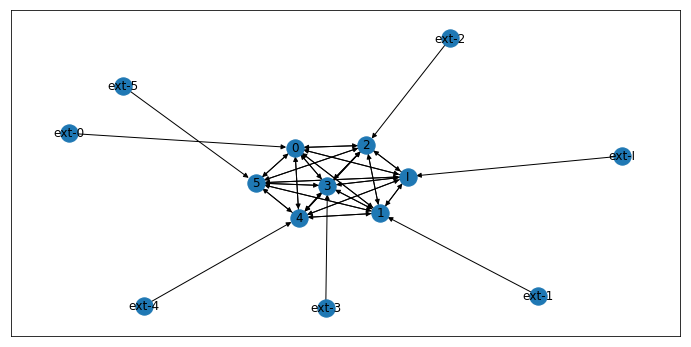

In [444]:
plt.figure(figsize=(12, 6))
nx.draw_networkx(population_graph)

In [445]:
def _get_J(node, graph):
    return 1 + gamma_NMDA * np.exp(-beta_NMDA * graph.nodes[node]['V_avg'])

def _get_rho1(edge, graph):
    assert graph.nodes[edge[0]]['cell_type'] == 'pyramidal'
    g_NMDA_kprimek = graph.edges[edge]['w']*graph.nodes[1]['g_NMDA']
    J = _get_J(edge[1], graph)
    C_k = graph.nodes[edge[0]]['C_k']
    g_m = graph.nodes[edge[1]]['g_m']
    return g_NMDA_kprimek * C_k / (g_m * J)

def _get_rho2(edge, graph):
    assert graph.nodes[edge[0]]['cell_type'] == 'pyramidal'
    g_NMDA_kprimek = graph.edges[edge]['w']*graph.nodes[1]['g_NMDA']
    J = _get_J(edge[1], graph)
    C_k = graph.nodes[edge[0]]['C_k']
    V_avg = graph.nodes[edge[1]]['V_avg']
    g_m = graph.nodes[edge[1]]['g_m']
    return beta_NMDA * g_NMDA_kprimek * C_k * (V_avg - V_E) * (J - 1) / (g_m * J**2)

def _get_T(edge, graph):
    tau = tau_AMPA
    if graph.nodes[edge[0]]['cell_type'] == 'pyramidal':
        g_base = graph.nodes[edge[1]]['g_AMPA_rec']
    elif graph.nodes[edge[0]]['cell_type'] == 'external':
        g_base = graph.nodes[edge[1]]['g_AMPA_ext']
    elif graph.nodes[edge[0]]['cell_type'] == 'interneuron':
        g_base = graph.nodes[edge[1]]['g_GABA']
        tau = tau_GABA
    else:
        raise Exception('cell type not supported')
    g = g_base * graph.edges[edge]['w']
    g_m = graph.nodes[edge[1]]['g_m']
    C_k = graph.nodes[edge[0]]['C_k']
    return g * C_k * tau / g_m

def _get_Tn_summand(n, m, nu):
    assert n >= 1 and m >= 0
    tau_NMDA = alpha * tau_NMDA_rise * tau_NMDA_decay
    binom_coeff = (-1)**m * special.binom(n, m)
    numerator = tau_NMDA_rise * (1 + nu * tau_NMDA)
    denominator = tau_NMDA_rise * (1 + nu * tau_NMDA) + m * tau_NMDA_decay
    return binom_coeff * numerator / denominator

def _get_Tn(n, nu):
    assert n >= 1
    Tn = 0
    for m in np.arange(0, n+1):
        Tn += _get_Tn_summand(n, m, nu)
    return Tn

def psi(nu, n_truncate=5):
    """
    Computes fraction of open NMDA channels given presynaptic firing rate nu 
    up until truncation round-off n_truncate.
    """
    tau_NMDA = alpha * tau_NMDA_rise * tau_NMDA_decay
    coeff = nu * tau_NMDA / (1 + nu * tau_NMDA)
    summation = 0
    for n in np.arange(1, n_truncate+1):
        summand_coeff = ((-alpha * tau_NMDA_rise)**n) / special.factorial(n+1)
        summation += summand_coeff * _get_Tn(n, nu)
    return coeff * (1 + summation / (1 + nu * tau_NMDA))

def update_input(
    edge, graph,
    C_stim=0, nu_stim=0
):
    """
    In-place update of inputs via synapses at given edge. 
    Done in-place so that number of returned values is fixed.
    Use args `C_stim`, `nu_stim` to add extra stimulus input 
    to external inputs.
    """
    nu = graph.nodes[edge[0]]['nu']
    T = _get_T(edge, graph)
    if graph.nodes[edge[0]]['cell_type'] == 'pyramidal':
        graph.edges[edge]['input_AMPA'] = T * nu
        s_NMDA = psi(nu)
        graph.edges[edge]['input_NMDA_linear'] = _get_rho1(edge, graph) * s_NMDA
        graph.edges[edge]['input_NMDA_nonlinear'] = _get_rho2(edge, graph) * s_NMDA
    elif graph.nodes[edge[0]]['cell_type'] == 'external':
        ext_input = T * nu
        # custom input
        if C_stim > 0 and nu_stim > 0:
            C_k = graph.nodes[edge[0]]['C_k']
            T_stim = T * C_stim / C_k
            ext_input += T_stim * nu_stim
        graph.edges[edge]['input_AMPA'] = ext_input
    elif graph.nodes[edge[0]]['cell_type'] == 'interneuron':
        graph.edges[edge]['input_GABA'] = T * nu
    return None

def compute_Sk(node, graph):
    """
    Computes the shunting factor for the input node. 
    Not needed for 'external' population.
    """
    Sk = 1
    for edge in graph.in_edges(node):
        for input_key in ['input_AMPA', 'input_NMDA_linear', 'input_NMDA_nonlinear', 'input_GABA']:
            if graph.edges[edge][input_key]:
                Sk += graph.edges[edge][input_key]
    graph.nodes[node]['S'] = Sk
    return Sk

def compute_muk(node, graph):
    """
    In-place update as well.
    No need to compute on 'external' node.
    Run after computing Sk.
    """
    Sk = graph.nodes[node]['S']
    muk = 0
    for edge in graph.in_edges(node):
        for input_key in ['input_AMPA', 'input_NMDA_linear']:
            if graph.edges[edge][input_key]:
                muk += graph.edges[edge][input_key] * (V_E - V_L)
        input_key = 'input_NMDA_nonlinear'
        if graph.edges[edge][input_key]:
            V_avg = graph.nodes[node]['V_avg']
            muk += graph.edges[edge][input_key] * (V_avg - V_L)
        input_key = 'input_GABA'
        if graph.edges[edge][input_key]:
            # this evaluates to zero increment with default parameters
            muk += graph.edges[edge][input_key] * (V_I - V_L)
    muk = muk / Sk
    graph.nodes[node]['mu'] = muk
    return muk

def compute_tauk(node, graph):
    """Run after computing Sk."""
    Sk = graph.nodes[node]['S']
    tau_eff = graph.nodes[node]['C_m'] / (Sk * graph.nodes[node]['g_m'])
    graph.nodes[node]['tau_eff'] = tau_eff
    return tau_eff

# TODO: also update when adding custom input
def compute_sigmak(
    node, graph,
#     nu_ext=None,
#     C_ext=None
):
    """
    Computes standard deviation of noise, due to AMPA,ext fluctuations.
    No need to compute on 'external' node.
    Compute after computing tau_k.
    """
#     if nu_ext is None:
    nu_ext = graph.nodes['ext-'+str(node)]['nu']
#     if C_ext is None:
    C_ext = graph.nodes['ext-'+str(node)]['C_k']
    V_avg = graph.nodes[node]['V_avg']
    g_AMPA_ext = graph.nodes[node]['g_AMPA_ext']
    tau_k = graph.nodes[node]['tau_eff']
    g_m = graph.nodes[node]['g_m']
    C_m = graph.nodes[node]['C_m']
    # tau_m = C_m / g_m => tau_m * g_m = C_m
    sigmak_squared = (g_AMPA_ext * (V_avg - V_E) * tau_AMPA / C_m) ** 2
    sigmak_squared *= C_ext * nu_ext * tau_k
    sigmak = np.sqrt(sigmak_squared)
    graph.nodes[node]['sigma'] = sigmak
    return sigmak

def _siegert_integrand(u):
    return np.exp(u**2)*(1+special.erf(u))

def _phi_siegert(
    tau_rp, tau_eff, lower_bound, upper_bound,
    tolerance=1.49e-08, limit=1000
):
    integral, error = integrate.quad(
        _siegert_integrand,
        lower_bound,
        upper_bound,
        limit=limit,
        epsabs=tolerance
    )
        
    return (tau_rp + tau_eff * np.sqrt(np.pi) * integral)**-1

def _siegert_integrand_lowerbound(mu, sigma):
    return (V_reset - V_L - mu)/sigma

def _siegert_integrand_upperbound(
    mu, sigma, tau_eff=None
):
    usual_bound = (V_thr - V_L - mu)/sigma
    if tau_eff is None:
        return usual_bound
    tau_ratio = tau_AMPA / tau_eff
    multiplier = (1 + 0.5 * tau_ratio)
    summands = 1.03*np.sqrt(tau_ratio) - 0.5 * tau_ratio
    return usual_bound * multiplier + summands

def compute_phi(
    node, graph,
):
    """Computes first-passage time"""
    mu = graph.nodes[node]['mu']
    sigma = graph.nodes[node]['sigma']
    tau_eff = graph.nodes[node]['tau_eff']
    tau_rp = graph.nodes[node]['tau_rp']
    
    lowerbound = _siegert_integrand_lowerbound(mu, sigma)
    upperbound = _siegert_integrand_upperbound(mu, sigma, tau_eff=None)
    phi = _phi_siegert(tau_rp, tau_eff, lowerbound, upperbound)
#     graph.nodes[node]['nu'] = nu
    return phi

def compute_nu_euler(
    node, graph,
    dt=defaultdt,
#     mu=None, sigma=None, tau_eff=None, tau_rp=None, phi=None
):
    """
    Updates and returns new firing rate nu_next, assuming the rate 
    linearly decays to its steady state and uses Euler simulation.
    """
    phi = compute_phi(node, graph)
    tau_eff = graph.nodes[node]['tau_eff']
    nu_old = graph.nodes[node]['nu']
    dnu_dt = (-nu_old + phi)/tau_eff
    nu_new = nu_old + dt * dnu_dt
    graph.nodes[node]['nu_next'] = nu_new
    return nu_new

def compute_V_avg(node, graph):
    # cf. pg 449, eqn 15.52, Fend
    mu = graph.nodes[node]['mu']
#     nu = graph.nodes[node]['nu']
    phi = compute_phi(node, graph)
    tau = graph.nodes[node]['tau_eff']
    V_avg = mu - (V_thr - V_reset)*tau*phi
    graph.nodes[node]['V_avg'] = V_avg
    return V_avg

In [446]:
rates = {
    node: [] for node in population_graph.nodes
    if not str(node).startswith('ext')
}
mu_min = 100 * b2.mV
mu_max = -100 * b2.mV
sigma_min = 100 * b2.mV
sigma_max = -100 * b2.mV
tau_min = 100 * b2.ms
tau_max = -100 * b2.ms

T = 100 * b2.ms
for t in np.arange(0, T, defaultdt):
    # step 1
    if t > 50*b2.ms and t < 70*b2.ms:
        population_graph.nodes['ext-1']['nu'] = 10 * b2.Hz
    else:
        population_graph.nodes['ext-1']['nu'] = 3 * b2.Hz
    for edge in population_graph.edges:
        update_input(
            edge, population_graph,
        )
    # steps 2 to 7
    for node in population_graph.nodes:
        if str(node).startswith('ext'):
            continue
        # step 2
        Sk = compute_Sk(node, population_graph)
        # step 3
        muk = compute_muk(node, population_graph)
        if muk > mu_max:
            mu_max = muk
        if muk < mu_min:
            mu_min = muk
        
        tauk = compute_tauk(node, population_graph)
        if tauk > tau_max:
            tau_max = tauk
        if tauk < tau_min:
            tau_min = tauk
            
        sigmak = compute_sigmak(node, population_graph)
        if sigmak > sigma_max:
            sigma_max = sigmak
        if sigmak < sigma_min:
            sigma_min = sigmak

        # skip noise, step 4
        # step 5 (using rate decay, not input decay)
        # hk = muk  # not used
        # step 6
        nu_next = compute_nu_euler(node, population_graph)
        
        rates[node].append(nu_next)
        # step 7
#         V_avg = compute_V_avg(node, population_graph)  # updating this breaks things
        # step 7.2: update weights...
    # step 8
    for node in population_graph.nodes:
        if str(node).startswith('ext'):
            continue
        population_graph.nodes[node]['nu'] = population_graph.nodes[node]['nu_next']

WARNING    /home/dean/anaconda3/envs/masters/lib/python3.7/site-packages/ipykernel_launcher.py:177: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 [py.warnings]
WARNING    /home/dean/anaconda3/envs/masters/lib/python3.7/site-packages/ipykernel_launcher.py:177: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
 [py.warnings]


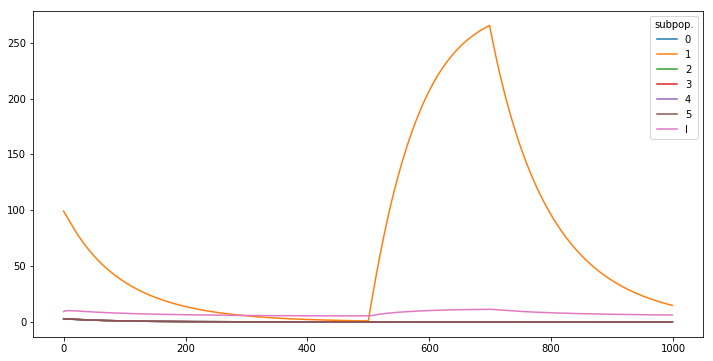

In [447]:
plt.figure(figsize=(12, 6))

for node, rate_trace in rates.items():
    plt.plot(rate_trace, label=node)
# plt.xlim(0.00, 0.002)
# plt.ylim(0.00, 50)
plt.legend(title='subpop.')

In [448]:
population_graph.edges[('ext-2', 2)], population_graph.nodes[2]

({'input_AMPA': 0.39936000000000005,
  'input_NMDA_linear': None,
  'input_NMDA_nonlinear': None,
  'input_GABA': None,
  'w': 1.0,
  'dynamic': True},
 {'name': 'selective-2',
  'cell_type': 'pyramidal',
  'C_m': 0.5 * nfarad,
  'g_m': 25. * nsiemens,
  'tau_rp': 2. * msecond,
  'C_k': 80,
  'g_AMPA_rec': 104. * psiemens,
  'g_AMPA_ext': 2.08 * nsiemens,
  'g_NMDA': 0.327 * nsiemens,
  'g_GABA': 1.25 * nsiemens,
  'nu': 160.42453469 * mhertz,
  'nu_next': 160.42453469 * mhertz,
  'mu': 14.50132421 * mvolt,
  'sigma': 2.14135858 * mvolt,
  'tau_eff': 10.01387796 * msecond,
  'S': 1.997228255146441,
  'V_avg': -52.5 * mvolt})

In [449]:
population_graph.nodes[2]['mu'] - (V_thr - V_reset) * population_graph.nodes[2]['nu']*population_graph.nodes[2]['tau_eff']

14.49329185 * mvolt

In [450]:
mu_min, \
mu_max, \
sigma_min, \
sigma_max, \
tau_min, \
tau_max 

(14.41217039 * mvolt,
 33.93921135 * mvolt,
 1.82665471 * mvolt,
 3.28793036 * mvolt,
 3.89335019 * msecond,
 10.39116732 * msecond)

In [451]:
mu, sig = 21.15323206 * b2.mV,  2.00802837 *b2.mV
lowerbound = _siegert_integrand_lowerbound(mu, sig)
upperbound = _siegert_integrand_upperbound(mu, sig, None)
phi = _phi_siegert(tau_rp, tau_eff, lowerbound, upperbound)

In [452]:
tau_rp = 2. * b2.ms
datapoints = []
steps = 20
mu_vals = np.linspace(0*b2.mV, mu_max, steps)
sigma_vals = np.linspace(sigma_min, sigma_max, steps)
for mu in mu_vals:
    for sigma in sigma_vals:
        tau_eff = 7 * b2.ms
        lowerbound = _siegert_integrand_lowerbound(mu, sigma)
        upperbound = _siegert_integrand_upperbound(mu, sigma, None)
        phi = _phi_siegert(tau_rp, tau_eff, lowerbound, upperbound)
        datapoints.append( (mu, sigma, tau_eff, phi) )

WARNING    /home/dean/anaconda3/envs/masters/lib/python3.7/site-packages/ipykernel_launcher.py:177: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 [py.warnings]
WARNING    /home/dean/anaconda3/envs/masters/lib/python3.7/site-packages/ipykernel_launcher.py:177: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
 [py.warnings]


In [453]:
# tolerance=1.49e-08
# # tolerance=1.49e-06
# limit=800
# for mu in mu_vals:
#     for sigma in sigma_vals:
#         lowerbound = _siegert_integrand_lowerbound(mu, sigma)
#         upperbound = _siegert_integrand_upperbound(mu, sigma, None)
#         integral, error = integrate.quad(
#             _siegert_integrand,
#             lowerbound,
#             upperbound,
#             limit=limit,
#             epsabs=tolerance
#         )
#         if error > tolerance:
#             print(mu, sigma)
#             print(lowerbound, upperbound, error)
#             break
#     if error > tolerance:
#         break

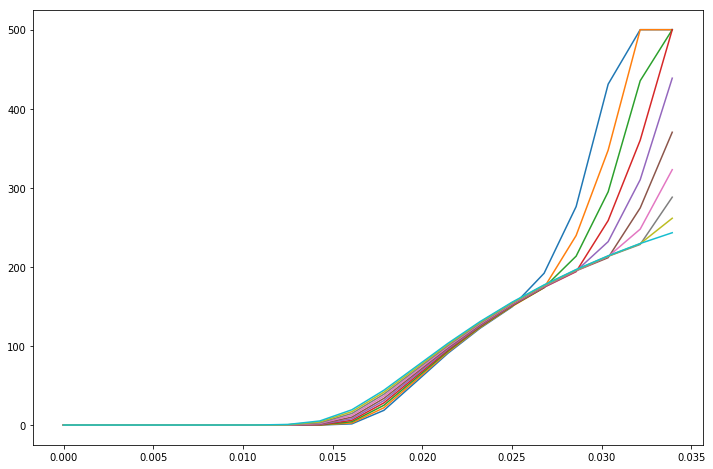

In [454]:
plt.figure(figsize=(12, 8))
for i in range(0, steps, 2):
    plt.plot(mu_vals, [x[-1] for x in datapoints[i::steps]]);

In [290]:
# integral, error, info = integrate.quad(_siegert_integrand, l, u, full_output=1, limit=100)

In [293]:
# K = info['last']
# lower_bounds = info['alist'][:K]
# upper_bounds = info['blist'][:K]
# estimates = info['rlist'][:K]
# error_estimates = info['elist'][:K]

In [455]:
# for a, b, r, e in zip(lower_bounds, upper_bounds, estimates, error_estimates):
#     plt.plot([a, b], [r, r], 'k')

In [298]:
def custom_integrate(
    func, lower, upper,
    intervals=50
):
    bounds = np.linspace(lower, upper, intervals + 1)
    diff_bounds = np.diff(bounds)
    eval_points = bounds[1:] - diff_bounds/2
    f_vals = func(eval_points)
    integral = np.dot(f_vals, diff_bounds)
    return integral, eval_points, bounds

# sq = lambda x: x
# custom_integrate(sq, 0, 1)
l, u = 0.7267400516705649, 3.739140681571717
custom_I, eval_points, bounds = custom_integrate(_siegert_integrand, l, u, intervals=10000)
custom_I

328426.3631023441

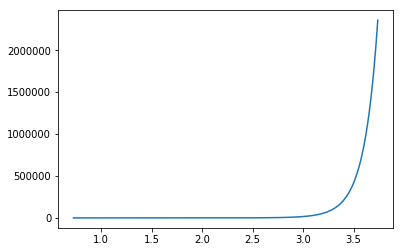

In [300]:
plt.plot(eval_points, _siegert_integrand(eval_points))

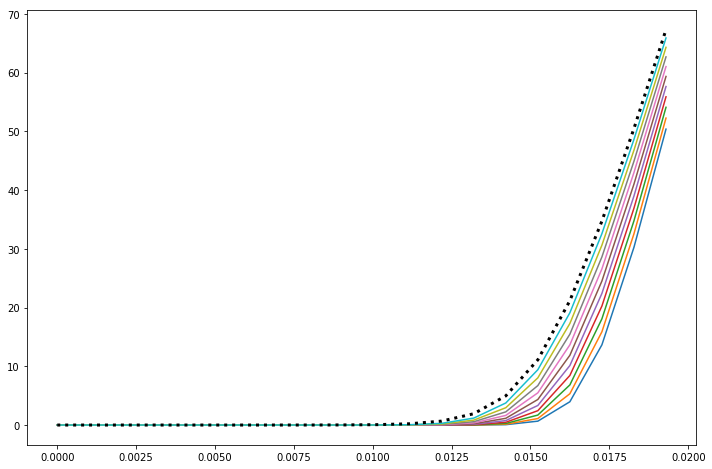

In [426]:
# Wong and Wang function doesn't fit well, or does it?
phi_fast = []

# mu_fast = np.linspace(0, 100, 30)*b2.mV

plt.figure(figsize=(12, 8))
for i in range(0, steps, 2):
    plt.plot(mu_vals, [x[-1] for x in datapoints[i::steps]]);

for mu in mu_vals:
    I_syn = mu * g_m_E
    cE = 310 * (b2.nA * b2.second)**-1 * 2.22
    IE = 125 * b2.Hz * 2.12
    gE = 0.16 * b2.second / 2.0
    numerator = cE * I_syn - IE
    denominator = 1 - np.exp(-gE*(numerator))
    phi_fast.append( numerator / denominator )

plt.plot(mu_vals, phi_fast, 'k:', lw=3)

In [57]:
# from mpl_toolkits import mplot3d

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(
#     [x[0] for x in datapoints],
#     [x[1] for x in datapoints],
#     [x[3] for x in datapoints]);

error: 7.627637887543144e+57


ValueError: x and y must have same first dimension, but have shapes (80,) and (1,)

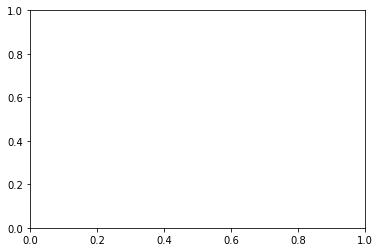

In [126]:
sigma = 2 * b2.mV
tau = 2 * b2.ms

V_averages = []
mu_vals = np.linspace(-5*b2.mV, mu_max, 80)
for mu in mu_vals:
    lowerbound = _siegert_integrand_lowerbound(
        mu=mu, sigma=sigma
    )
    upperbound = _siegert_integrand_upperbound(
        mu=mu, sigma=sigma,
        tau_eff=None
    )
    phi = _phi_siegert(
        2*b2.ms,
        tau,
        lowerbound, upperbound,
    )
    V_avg = (mu - phi * tau * (V_thr - V_reset)) / b2.mV
    V_averages.append(V_avg)
    break
plt.plot(mu_vals, V_averages)

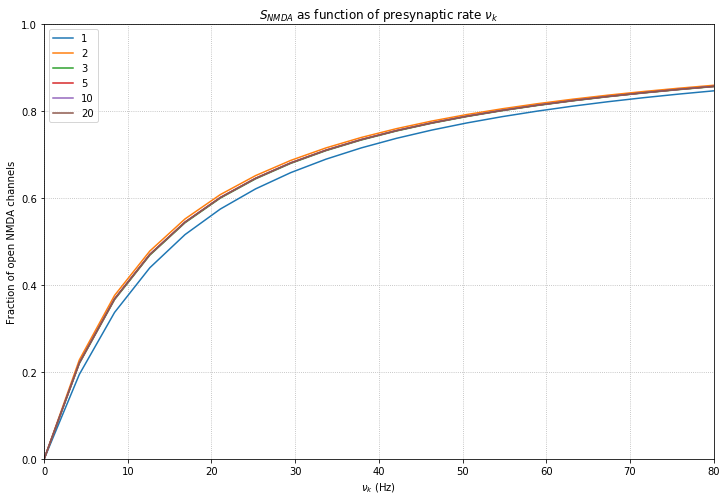

In [83]:
# we can truncate early
plt.figure(figsize=(12, 8))
Hz = np.linspace(0, 80, 20) * b2.Hz
for n_truncate in [1, 2, 3, 5, 10, 20]:
    s_NMDA_vals = []
    for hz in Hz:
        s_NMDA_vals.append(psi(hz, n_truncate=n_truncate))
    plt.plot(Hz / b2.Hz, s_NMDA_vals, label=n_truncate)
plt.grid(ls=':')
plt.legend(title='$n$ truncation')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 80.0])
plt.title(r'average $\langle s_{NMDA} \rangle$ as function of presynaptic rate $\nu_k$')
plt.xlabel(r'$\nu_k$ (Hz)')
plt.ylabel('Fraction of open NMDA channels')
plt.show()

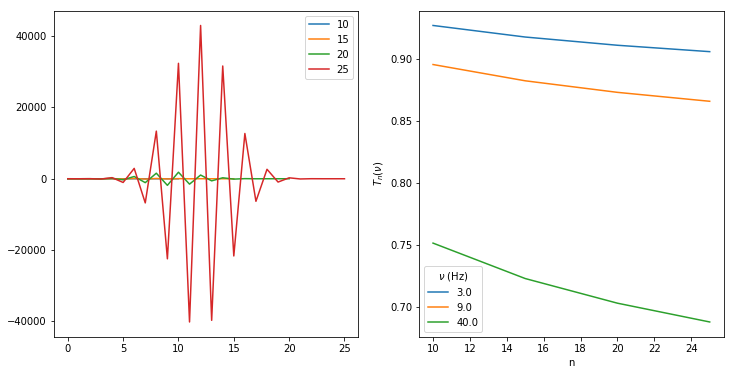

In [176]:
# special.binom(5, 5), special.factorial(4)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
Hz_vals = [3 *b2.Hz, 9 *b2.Hz, 40 *b2.Hz]

N = np.arange(10, 30, 5)
for hz in Hz_vals:
    cumsums = []
    for n in N:
        M = np.arange(0, n+1)
        Tn_summands = []
        for m in M:
            Tn_summands.append( _get_Tn_summand(n, m, hz) )
        cumsums.append( np.sum(Tn_summands))
        if hz == 40 *b2.Hz:
            axes[0].plot(M, Tn_summands, label=n)
    axes[1].plot(N, cumsums, label=hz / b2.Hz)
axes[0].legend()
axes[1].legend(title=r'$\nu$ (Hz)')
axes[1].set_xlabel('n')
axes[1].set_ylabel(r'$T_n(\nu)$')
plt.show()

In [64]:
tau_NMDA_rise

(2. * msecond,)